## plot the mcmc sampling result

In [ ]:
import os, sys
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap
from getdist import plots
from desilike.samples import plotting, Chain, Profiles
from desilike.parameter import ParameterCollection
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [ ]:
sys.path.append('../')
from helper import PLANCK_COSMOLOGY, REDSHIFT_BIN_LSS
from plotting_tools import get_mcmc_plot_args, COLOR_TRACERS, COLOR_TRACER_GRADIENT,  get_namespace, plot_observable, plot_mcmc_walkers
from fitting_tools import load_blinded_data_pip, load_bins, get_template, get_theory, get_measurement_fn, get_observable_likelihood
%load_ext autoreload
%autoreload 2

RESULT_DIR = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results'
SAVE_DIR = '/global/homes/s/shengyu/Y3/blinded_data_splits/main/results'
save_fig = True

In [ ]:
# fit settings
fit       = 'FM' # 'FM' 'SF'
option  = '_wq_prior' if fit == 'SF' else '' # '_wq_prior' only for SF
cosmology = 'LCDM' # LCDM, nuCDM, w0waCDM
theory = 'vel'
task = f'{fit}fit_{cosmology}_{theory}'

# load all the chains
(mcmc_args, getdist_args) = get_mcmc_plot_args(task)
(remove_burnin , slice_step) = (mcmc_args[key] for key in ['remove_burnin', 'slice_step'])

tracers = ['BGS','LRG','ELG','QSO'] # 'BGS','LRG', 'ELG', 'QSO' 
weight_type = 'default_fkp'
regions = ['GCcomb', 'NGC', 'SGC', 'N', 'SNGC', 'Scomb', 'noDEScomb','SnoDEScomb'] # "GCcomb", "NGC", "SGC", "N", 'S', 'noDES', 'SnoDES'
TRACER_BINS = [(tracer, zrange) for tracer, zranges in REDSHIFT_BIN_LSS.items()
               if tracer in tracers for zrange in zranges]
TRACER_BINS = TRACER_BINS[:]
all_chains = {}
for tracer, zrange in TRACER_BINS:
    for region in regions:
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        chain_fn = (RESULT_DIR + f'/full-shape/mcmc/chain_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}{option}.npy')
        print(f'[LOAD:] {chain_fn}')
        chain = Chain.load(chain_fn)
        all_chains[f'{tracer}_{zrange}_{region}'] = chain

[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_BGS_BRIGHT-21.35_z0.1-0.4_GCcomb_default_fkp.npy
[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_BGS_BRIGHT-21.35_z0.1-0.4_NGC_default_fkp.npy
[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_BGS_BRIGHT-21.35_z0.1-0.4_SGC_default_fkp.npy
[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_BGS_BRIGHT-21.35_z0.1-0.4_N_default_fkp.npy
[LOAD:] /global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results/full-shape/mcmc/chain_FMfit_LCDM_vel_BGS_BRIGHT-21.35_z0.1-0.4_SNGC_default_fkp.npy
[LOAD:] /global/cf

## Plot the 1d constraints

/tmp/ipykernel_1323687/752698400.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


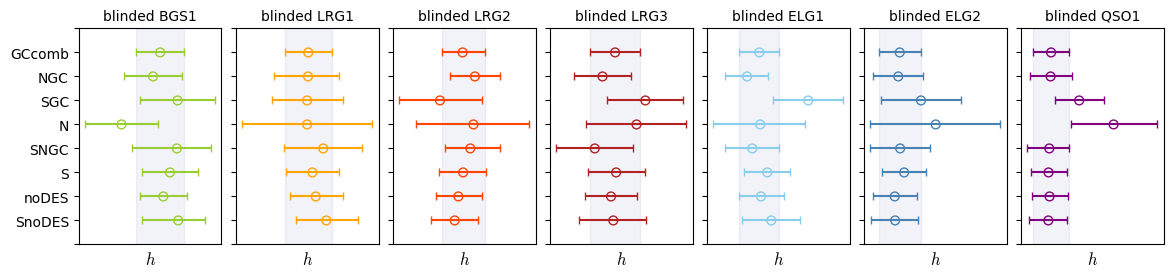

/tmp/ipykernel_1323687/752698400.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


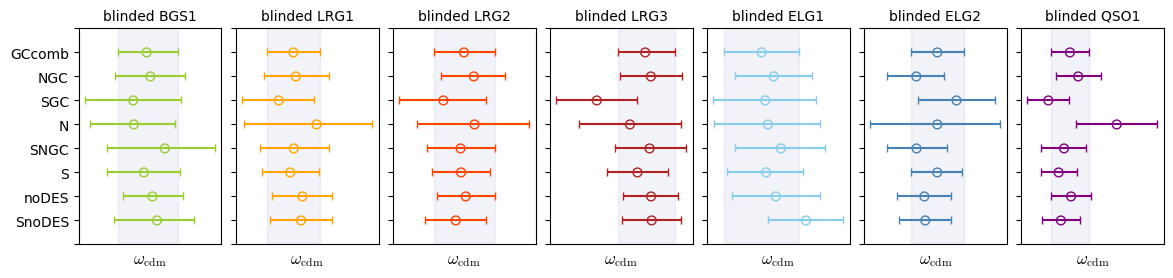

/tmp/ipykernel_1323687/752698400.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


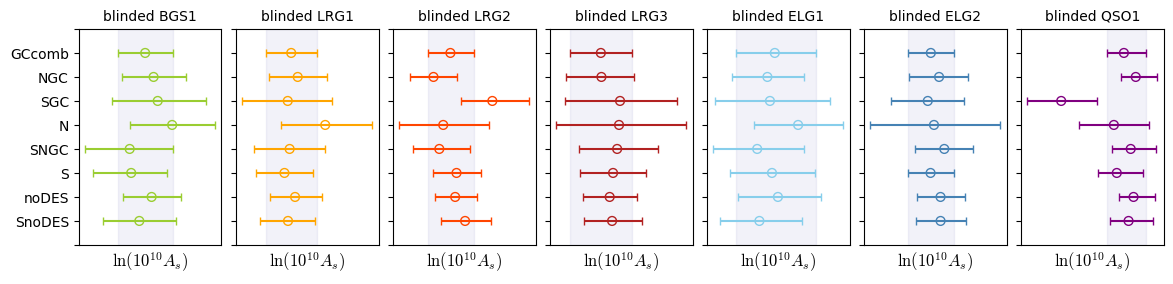

In [11]:
# regions = ["GCcomb", "NGC", "SGC", "N", 'S', 'noDES', 'SnoDES']
for param, param_label in zip(mcmc_args['params'], mcmc_args['params_label']):
    fig = plt.figure(figsize=(2*len(TRACER_BINS), 0.3*len(regions)))
    gs = gridspec.GridSpec(1, len(TRACER_BINS),  wspace=0.1, hspace=0.0, top=0.95, bottom=0.05)
    n_bins = len(TRACER_BINS)
    yticks = np.arange(len(regions)+2)
    for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        plt.rcParams['mathtext.fontset'] = 'cm' 
        ax = fig.add_subplot(gs[0, ind_col])
        tracer_label = get_namespace(tracer, zrange)
        ax.set_title(f"blinded {tracer_label}", fontsize=10)
        ax.set_yticks(yticks)
        if ind_col == 0:
            regions_label = [i[:-4] if i.endswith("Scomb") else i for i in regions]
            ax.set_yticklabels(['']+regions_label+[''], fontsize=10)
        else:
            ax.set_yticklabels([])
        ax.set_xlabel(param_label, fontsize =12)
        color = COLOR_TRACERS[tracer_label]
        # plot the truth values
        # ax.axvline(mcmc_args['true_values'][param], color='k', linestyle='--', linewidth=1, alpha=0.8,)
        # plot the 1d constraint
        for y, region in enumerate(regions):
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            mean = chain.mean(params=param)
            q05, q95 = chain.quantile(params=param)  # 5% and 95%
            # horizontal guide line for the region
            ax.scatter(mean, y+1,  edgecolors=color, facecolors='none', s=40)
            ax.errorbar(mean, y+1, xerr=[[mean - q05], [q95 - mean]], color=color, capsize=3)
            if region == 'GCcomb':
                ax.axvspan(q05, q95, color='darkblue', alpha=0.05, zorder=0)
            ax.set_ylim([0,len(regions)+1])
        ax.invert_yaxis()
        ax.set_yticks(ax.get_yticks()[::-1])
        # hide the x-axis
        # ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    plt.tight_layout()
    plt.show()
    if save_fig == True:
        fig.savefig(SAVE_DIR+f'/plots/1d_constraint_{fit}{option}_{param}_GCcompare.png', dpi=400, bbox_inches='tight')

## plot the best fit and clustering

/tmp/ipykernel_2311245/2540637947.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]


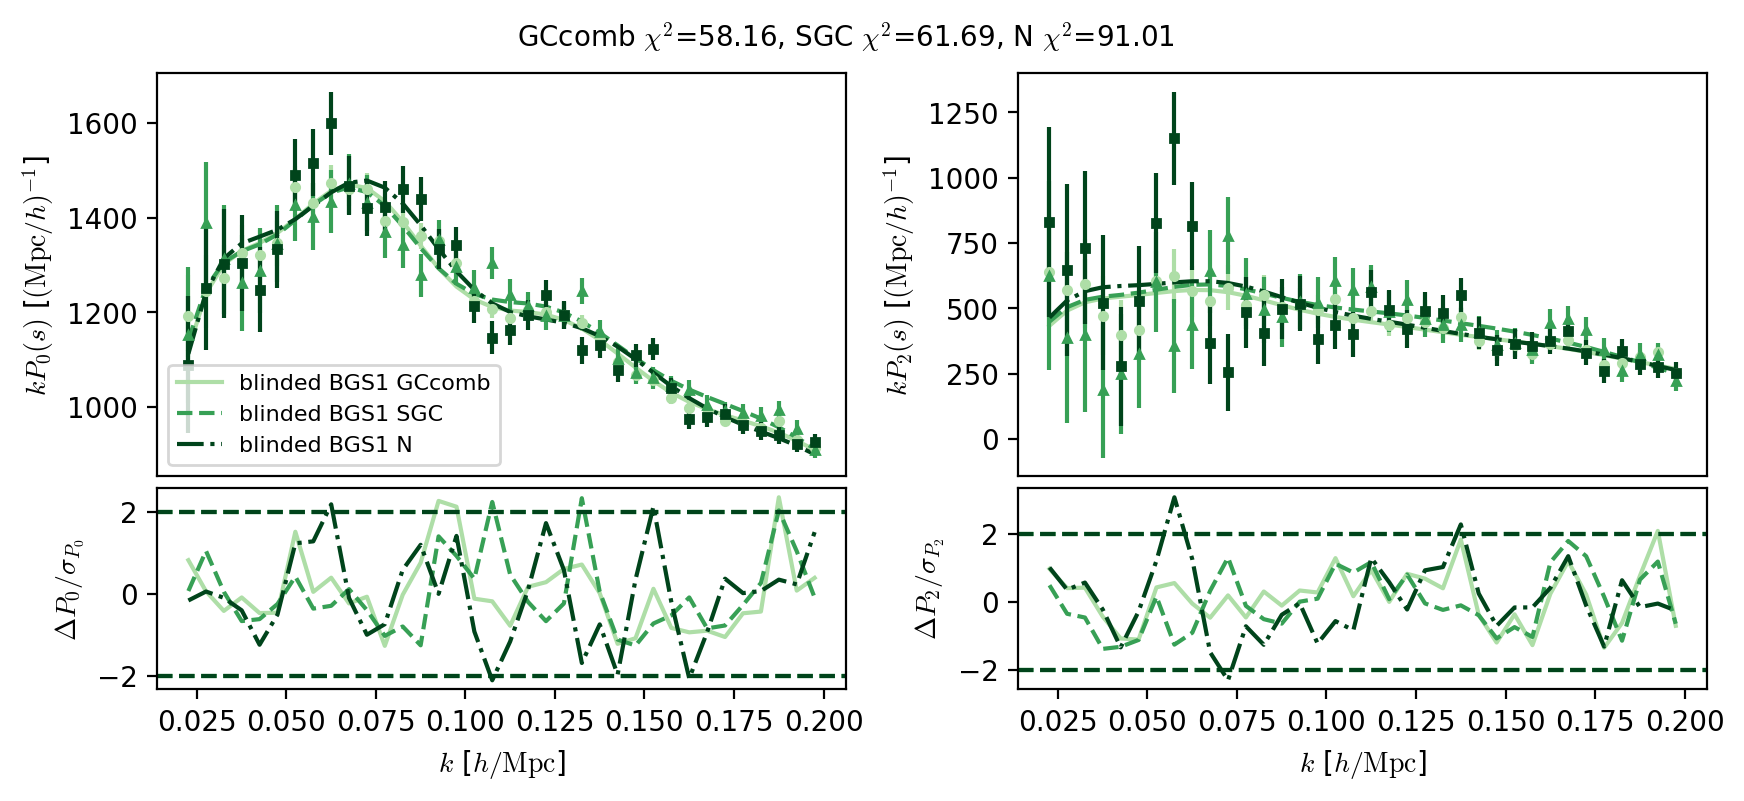

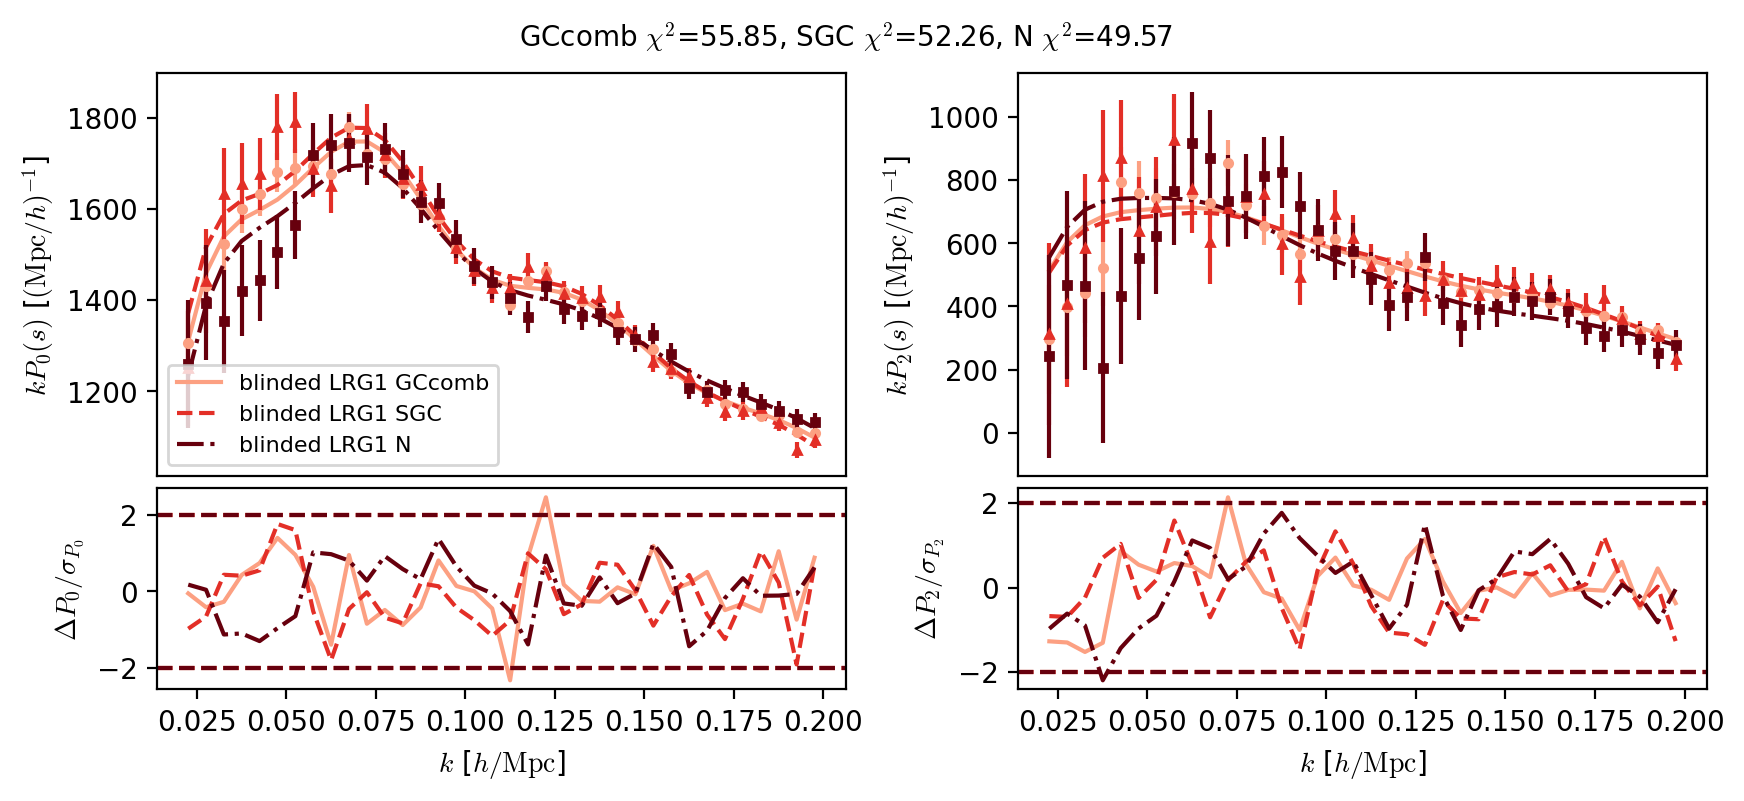

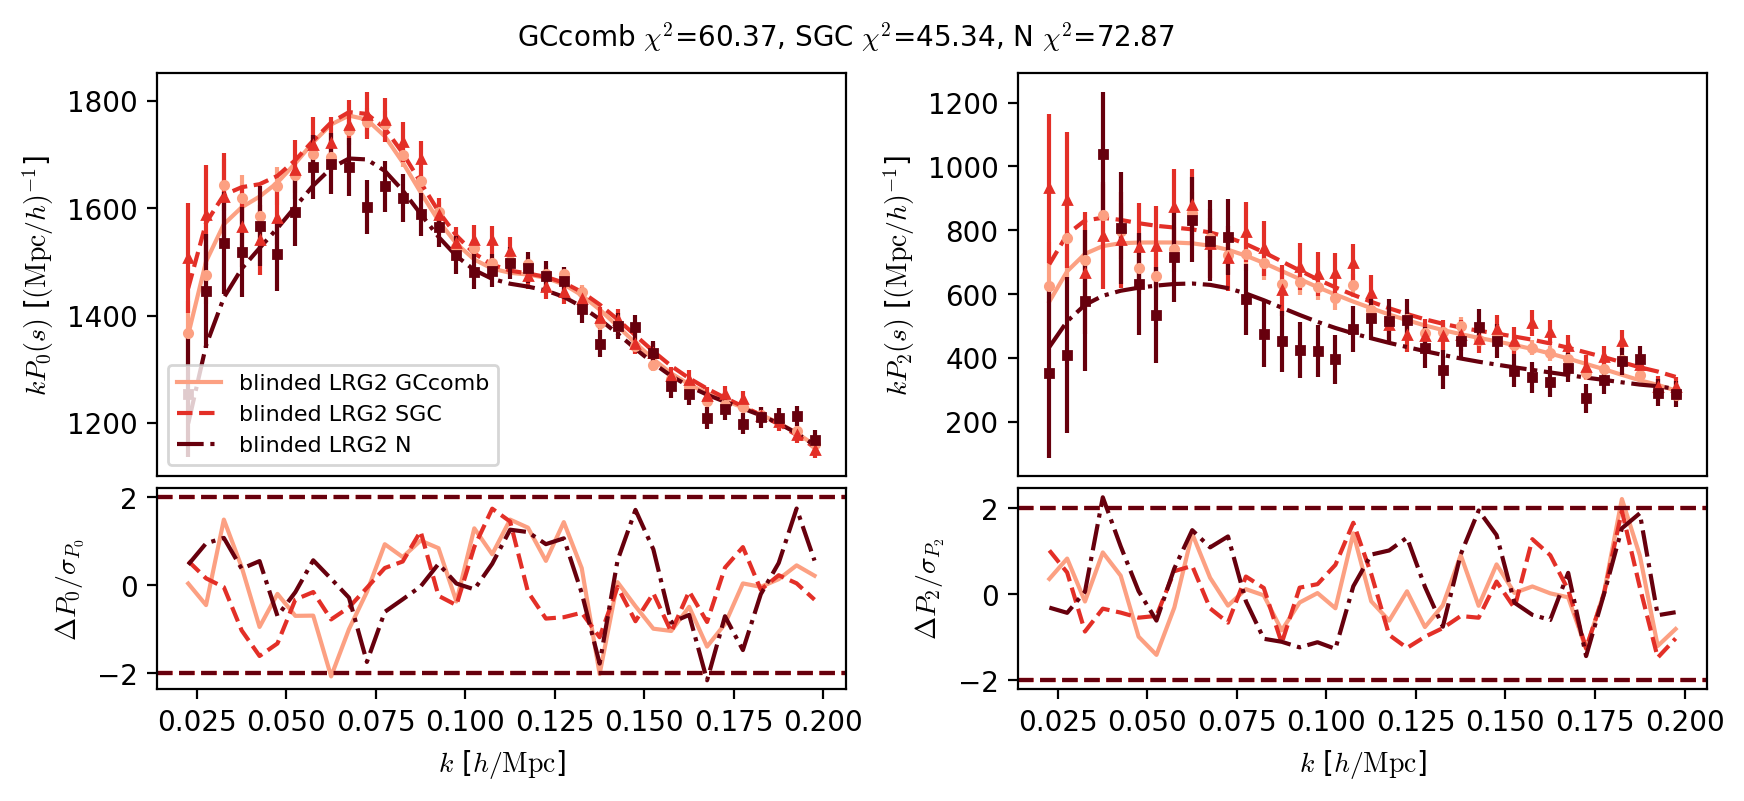

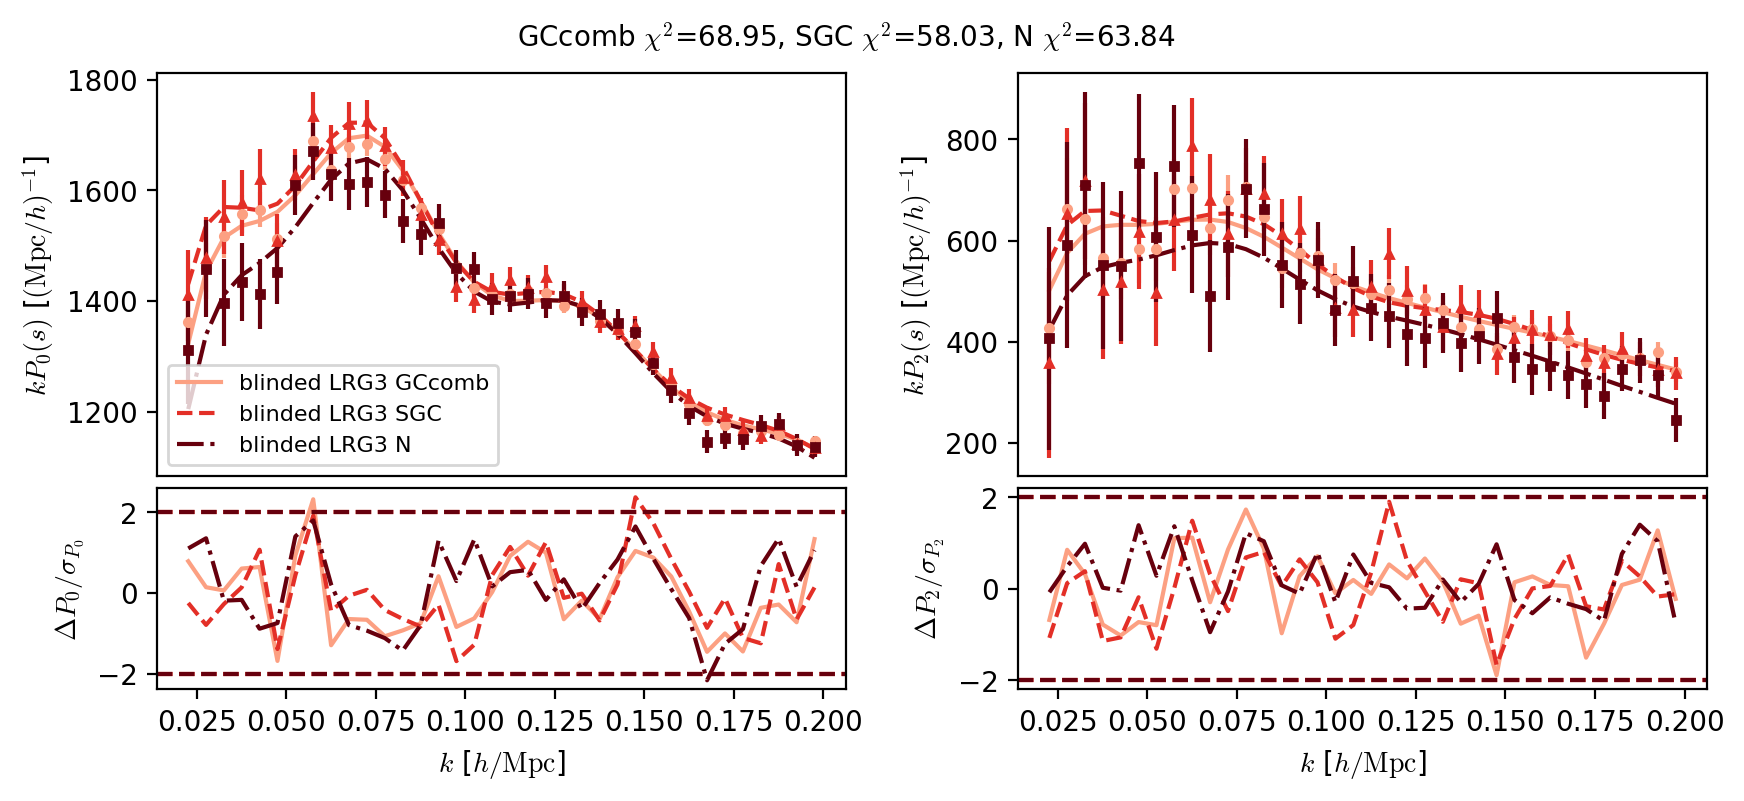

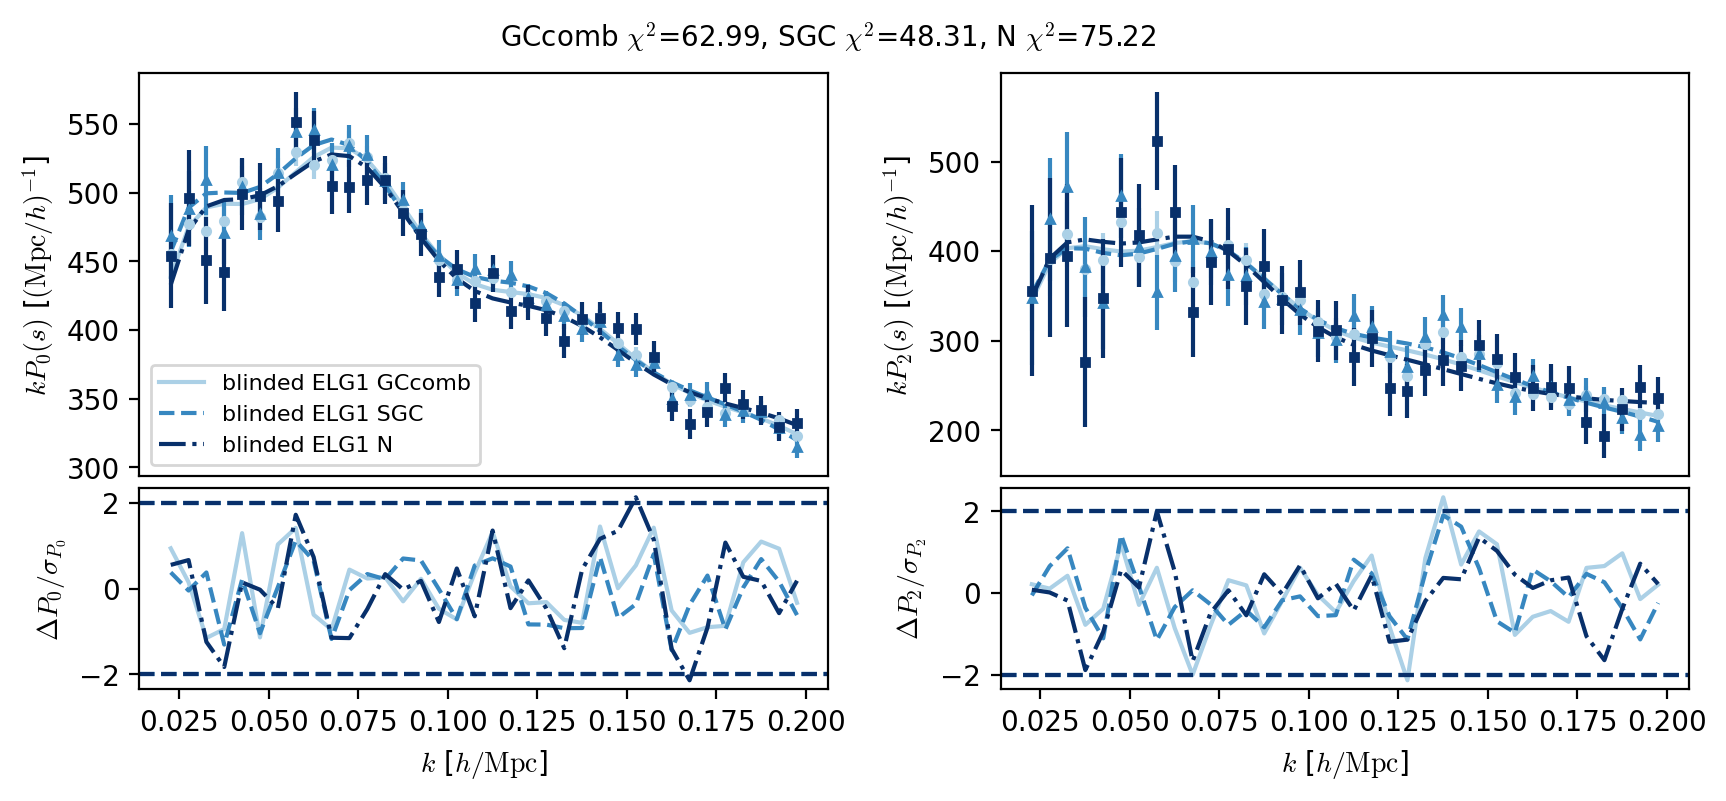

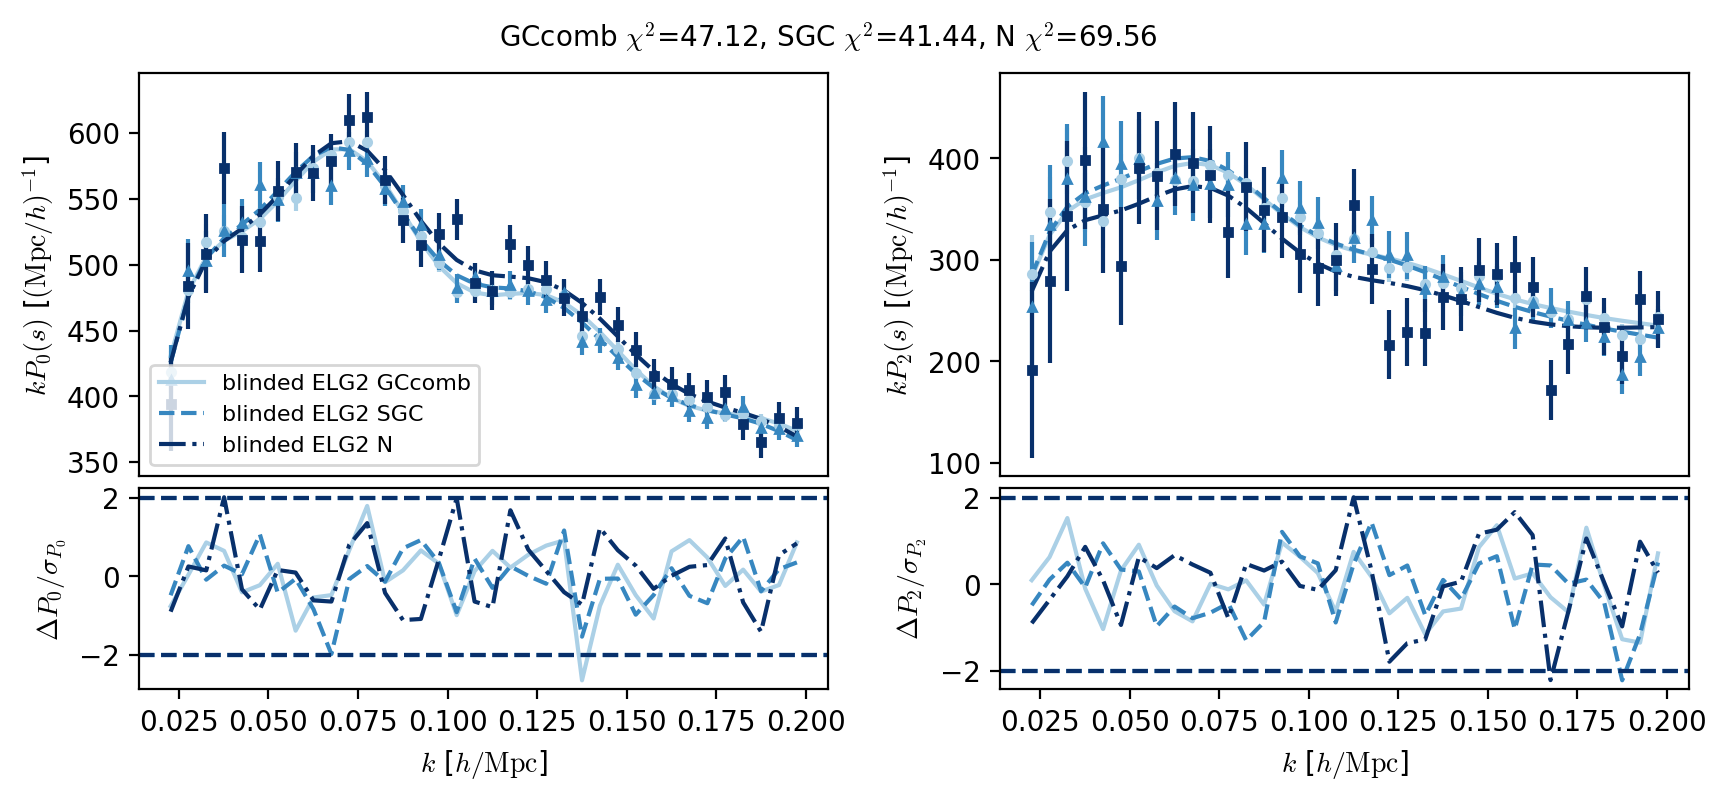

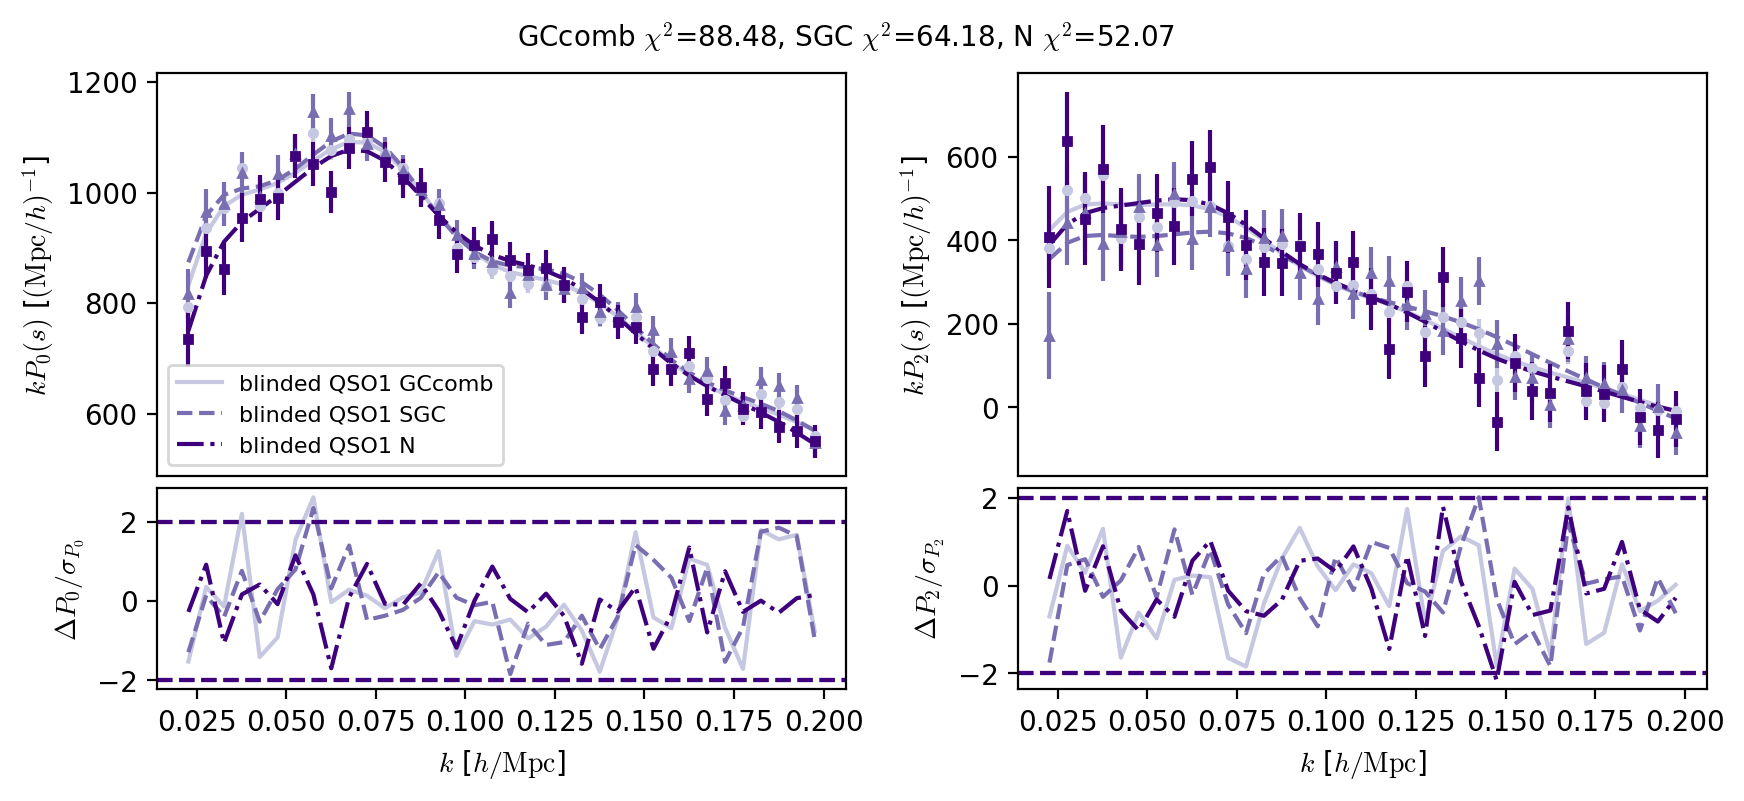

In [10]:
save_fig = True
regions = ['GCcomb','SGC','N']
(kmin, kmax, kbin, lenk) = load_bins('pk', 'y3_blinding')

for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
    tracer_label = get_namespace(tracer, zrange)
    colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]
    fmts = ['o', '^', 's', 'D', 'v', '<', '>', 'p', 'h', '*']
    lss  = ['-', '--', '-.', ':',':', '-.', '-.']
    chi2s = []
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.04, height_ratios=[2, 1])
    titles = []
    for j,region in enumerate(regions):
        plot_kwargs = {'color':color, 'label':f'blinded {tracer_label} {region}'}
        data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
        emulator_fn = RESULT_DIR+ f'/emulator/emulator_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}_k{kmin}-{kmax}{option}.npy'
        fit_args = {"corr_type": 'pk',  "bins_type": 'y3_blinding', "cov_type":None, 'emulator_fn':emulator_fn}
        (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
        chain0 = all_chains[f'{tracer}_{zrange}_{region}']
        chain = chain0.remove_burnin(remove_burnin)
        likelihood(**chain.choice(index='argmax', return_type='dict', input=True))
        chi2s.append(r'$\chi^2$'+f'={-2*likelihood():.2f}')
        self = observable
        data, theory, std = self.data, self.theory, self.std
        for ill, ell in enumerate(self.ells):
            ax_top = plt.subplot(gs[0, ill])
            label= f'blinded {tracer_label} {region}' if ill ==0 else None
            ax_top.errorbar(self.k[ill], self.k[ill] * data[ill], yerr=self.k[ill] * std[ill],
                            color=colormap[j], fmt = fmts[j], markersize= 3)
            ax_top.plot(self.k[ill], self.k[ill] * theory[ill], color = colormap[j], ls = lss[j], label = label)
            ax_bottom = plt.subplot(gs[1, ill])
            ax_bottom.plot(self.k[ill], (data[ill] - theory[ill]) / std[ill], color = colormap[j], ls = lss[j])
            ax_bottom.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize=10)
            for offset in [-2., 2.]:
                ax_bottom.axhline(offset, color=colormap[j], linestyle='--')
            ax_top.set_ylabel(r'$k P_{{{0:d}}}(s)$ [$(\mathrm{{Mpc}}/h)^{{-1}}$]'.format(ell), fontsize=10)
            ax_bottom.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell), fontsize=10)
            ax_top.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    ax = plt.subplot(gs[0, 0])
    title = ", ".join(f"{regions[i]} {chi2s[i]}" for i in range(len(regions)))
    # ax.set_title(title, fontsize=10)
    plt.text(1.0, 1.05, title, ha='center', va='bottom', transform=ax.transAxes, fontsize=10)
    ax.legend(fontsize=8, loc=3)
    plt.show()
    if save_fig == True:
        fig.savefig(SAVE_DIR+f'/plots/pk_with_{fit}{option}bf_{tracer_label}_DEScompare.png', dpi=300, bbox_inches='tight')

## Posterior Plot

/tmp/ipykernel_852903/3995684538.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]


Removed no burn in
Removed no burn in
Removed no burn in


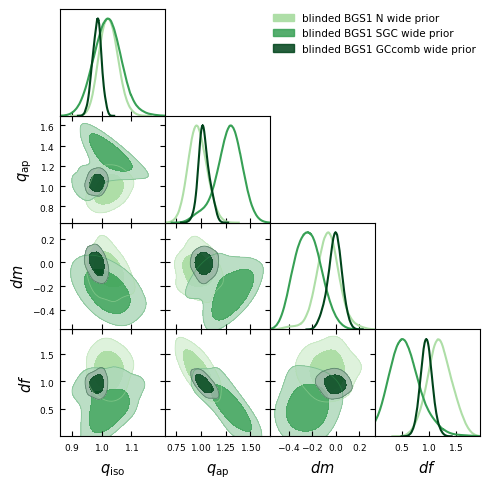

/tmp/ipykernel_852903/3995684538.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]


Removed no burn in
Removed no burn in
Removed no burn in


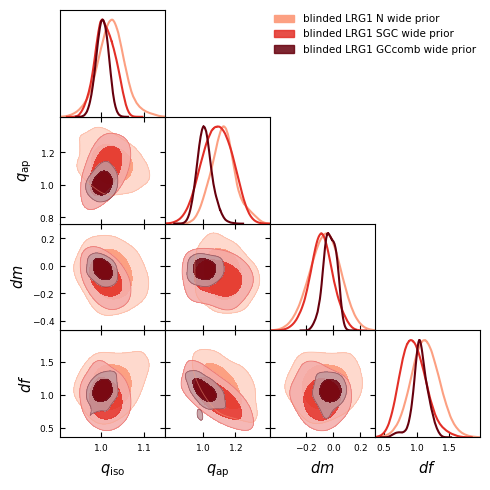

/tmp/ipykernel_852903/3995684538.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]


Removed no burn in
Removed no burn in
Removed no burn in


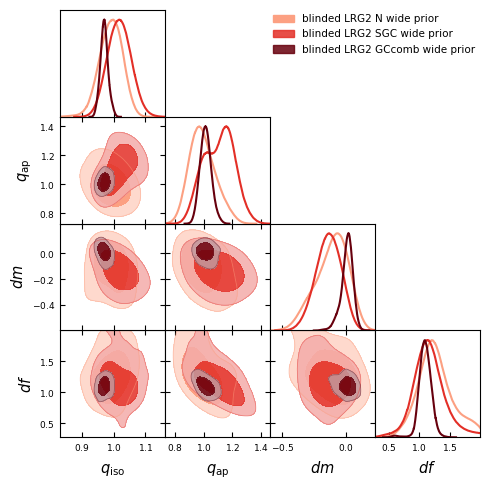

/tmp/ipykernel_852903/3995684538.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]


Removed no burn in
Removed no burn in
Removed no burn in


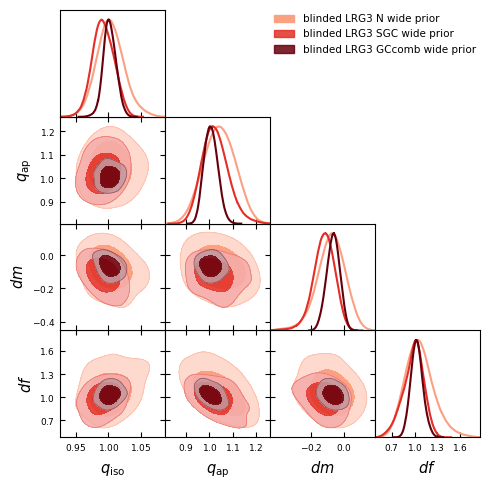

/tmp/ipykernel_852903/3995684538.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]


Removed no burn in
Removed no burn in
Removed no burn in


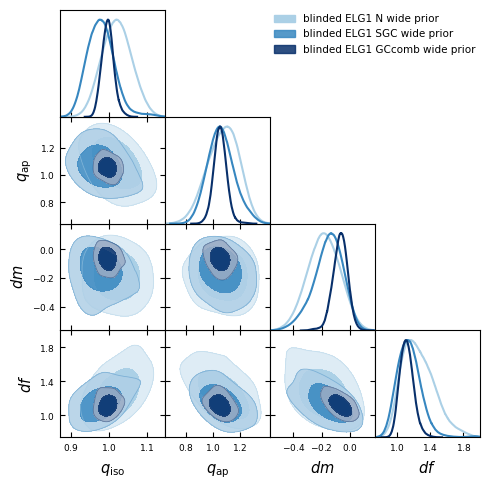

/tmp/ipykernel_852903/3995684538.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]


Removed no burn in
Removed no burn in
Removed no burn in


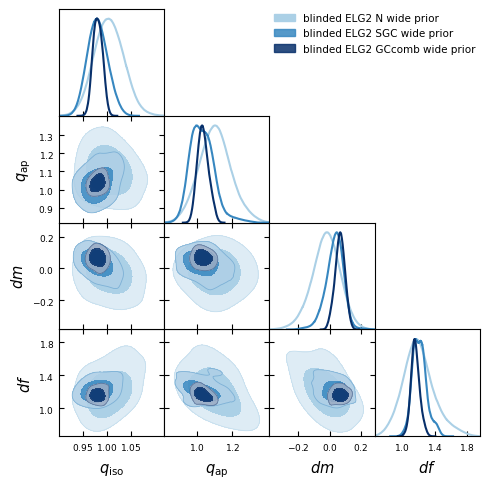

/tmp/ipykernel_852903/3995684538.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]


Removed no burn in
Removed no burn in
Removed no burn in


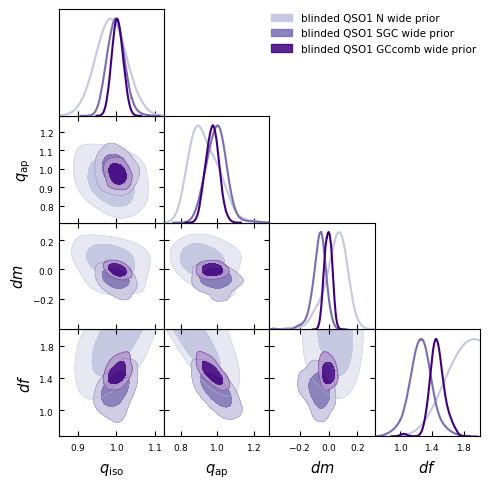

In [6]:
# posterior corener plot
params = mcmc_args['params']
# regions = ['GCcomb','SGC','N']
regions = ['N', 'SGC','GCcomb']

(mcmc_args, getdist_args) = get_mcmc_plot_args(task)
(remove_burnin , slice_step) = (mcmc_args[key] for key in ['remove_burnin', 'slice_step'])

for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
    chains = []
    colors = []
    labels = []
    # colormap = get_cmap('inferno')(np.linspace(0, 1, 6))
    map = 'vidirs'
    tracer_label = get_namespace(tracer, zrange)
    colormap = get_cmap(COLOR_TRACER_GRADIENT[tracer_label])(np.linspace(0, 1, len(regions)+1))[1:]
    for itask, region in enumerate(regions):
        param_value = []
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        chain_fn = RESULT_DIR +f'/full-shape/mcmc/chain_{fit}fit_LCDM_vel_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}{option}.npy'
        chain = Chain.load(chain_fn).remove_burnin(remove_burnin)[::slice_step]
        # chain = all_chains[f'{tracer}_{zrange}_{region}']
        chains.append(chain)
        colors.append(tuple(colormap[itask]))
        labels.append(f'blinded {tracer_label} {region} wide prior' if option == '_wq_prior' else f'blinded {tracer_label} {region}')
        # print(region, chain.to_stats(params = ['logA','b1p'], tablefmt='pretty'))
    g = plots.get_subplot_plotter()
    g.settings.fig_width_inch= 5
    g.settings.legend_fontsize = 12
    g.settings.axes_labelsize = 15
    g.settings.figure_legend_frame = False
    plotting.plot_triangle(chains, 
                            params = params,
                            legend_labels = labels, legend_loc= 'upper right',
                            contour_lws = 1.5, contour_colors = colors, contour_ls = ['-', '-', '-', '-'],
                            smoothed=True, show=False, filled = [True,True,True,True], g=g
                            )
    # true_values = mcmc_args['true_values']
    # for i, pi in enumerate(params):
    #     for j, pj in enumerate(params[:i+1]):
    #         ax = g.subplots[i, j]
    #         ax.axvline(true_values[pj], c='k', ls=':', lw=1.5)
    #         if i != j:
    #             ax.axhline(true_values[pi], c='k', ls=':', lw=1.5)
    if save_fig == True:
        g.fig.savefig(SAVE_DIR+f'/plots/corner_{fit}{option}_{tracer_label}_DEScompare', dpi=300, bbox_inches='tight')
    plt.show()

## Summary Table (the difference)

In [20]:
df = pd.read_csv(SAVE_DIR+f"/tables/table_{fit}{option}fit_values.csv")

# Compute std
df["std"] = 0.5 * (df["q95"] - df["q05"])

tracer_labels = get_namespace(tracer, zrange)

df["value"] = df.apply(lambda r: f"{r['mean']:.3f} ± {r['std']:.3f}", axis=1)
# ---- Build pivot table ----
table = df.pivot_table(index=["param", "region"],   # Multi-index rows
                       columns="name",              # each tracer_bin becomes a column
                       values="value",
                       aggfunc="first")

# Sort rows by param order and region order
region_order = regions
table = table.reindex(regions, level="region")
table = table.reindex(mcmc_args['params'], level="param")
table = table[['BGS1', 'LRG1', 'LRG2', 'LRG3', 'ELG1', 'ELG2', 'QSO1']]

chi2_rows = (df.groupby(["region", "name"])["chi2"].first().unstack("name"))
chi2_rows = chi2_rows.applymap(lambda x: f"{x:.2f}")
chi2_rows.index = pd.MultiIndex.from_product([["chi2"], chi2_rows.index], names=["param", "region"],)
table = pd.concat([table, chi2_rows])

pd.set_option("display.width", 1000)      # very wide output
print(table)

name                        BGS1            LRG1            LRG2            LRG3            ELG1            ELG2            QSO1
param region                                                                                                                    
qiso  GCcomb       0.983 ± 0.016   1.003 ± 0.014   0.970 ± 0.013   1.002 ± 0.009   0.996 ± 0.015   0.981 ± 0.009   1.003 ± 0.015
      NGC          0.992 ± 0.019   1.006 ± 0.020   0.969 ± 0.014   1.010 ± 0.012   1.006 ± 0.017   0.984 ± 0.011   1.010 ± 0.020
      SGC          1.022 ± 0.045   1.013 ± 0.024   1.014 ± 0.036   0.991 ± 0.016   0.981 ± 0.035   0.981 ± 0.020   0.998 ± 0.022
      N            1.024 ± 0.030   1.029 ± 0.030   0.994 ± 0.036   1.001 ± 0.019   1.023 ± 0.037   1.005 ± 0.030   0.986 ± 0.036
      SNGC         0.984 ± 0.024   1.003 ± 0.023   0.969 ± 0.015   1.014 ± 0.016   1.005 ± 0.020   0.982 ± 0.013   1.021 ± 0.023
      Scomb        0.977 ± 0.019   0.997 ± 0.015   0.972 ± 0.015   1.003 ± 0.010   0.993 ± 0.019 

/tmp/ipykernel_31687/2254638251.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chi2_rows = chi2_rows.applymap(lambda x: f"{x:.2f}")


In [9]:
import pandas as pd
df = pd.read_csv(SAVE_DIR + f"/tables/table_{fit}{option}fit_values.csv")
dC = pd.read_csv(SAVE_DIR+f"/tables/corr_coeff_region.csv")
regions = ["GCcomb", "NGC", "SGC", "N", 'SNGC', 'Scomb', 'noDEScomb','SnoDEScomb']

# Clean region labels just in case: strip spaces, newlines, etc.
df["region"] = df["region"].astype(str).str.strip()
df["std"] = 0.5 * (df["q95"] - df["q05"])

# ----- (GCcomb) -----
base = (
    df[df["region"] == "GCcomb"]
    [["param", "name", "mean", "std"]]
    .rename(columns={"mean": "mean_base", "std": "std_base"})
)

# ----- (Regions splits) -----
others = df[df["region"].isin(regions[1:])] \
    [["param", "region", "name", "mean", "std"]]
coeffs = dC[dC["region"].isin(regions[1:])] \
    [[ "name", "region", "r"]]

# ----- merge to attach baseline -----
merged = others.merge(base, on=["param", "name"], how="left")
merged = merged.merge(coeffs, on=["name", "region"], how="left")
merged["diff"] = (merged["mean"] - merged["mean_base"])
merged['sigma'] = np.sqrt(merged["std_base"]**2+merged["std"]**2 - merged["r"] * merged["std_base"]* merged["std"])
merged["norm"] = merged["diff"] / merged['sigma']
merged["val_str"] = merged["norm"].apply(lambda x: f"{x:.2f}")

# ----- pivot to table -----
table_diff = merged.pivot_table(index=["param", "region"],
    columns="name",
    values="val_str",
    aggfunc="first"
)

if fit == 'FM': 
    param_order = ["h", "omega_cdm", "logA"] 
elif fit == 'SF':
    param_order = ["qiso", "qap", "dm", "df"] 

# order
chi2 = df.pivot_table(
    index="region",
    columns="name",
    values="chi2",
    aggfunc="first",
)

region_order = regions[1:]
col_order    = ['BGS1', 'LRG1', 'LRG2', 'LRG3', 'ELG1', 'ELG2', 'QSO1']

table_diff = table_diff.reindex(param_order, level="param")
table_diff = table_diff.reindex(region_order, level="region")
table_diff = table_diff.reindex(columns=col_order)

# order regions + tracers
chi2_region_order = regions
chi2 = chi2.reindex(chi2_region_order)
chi2 = chi2.reindex(columns=col_order)

# format χ² (e.g. 1 decimal place)
chi2_str = chi2.applymap(lambda x: f"{x:.1f}")

# give χ² a MultiIndex to match (param, region)
chi2_str.index = pd.MultiIndex.from_product(
    [[r"chi2"], chi2_str.index],
    names=["param", "region"],
)

# concat value table + chi2 block
table_full = pd.concat([table_diff, chi2_str])
pd.set_option("display.width", 1000)

print(table_full)

name                   BGS1   LRG1   LRG2   LRG3   ELG1   ELG2   QSO1
param     region                                                     
h         NGC         -0.24  -0.01   0.49  -0.43  -0.55  -0.06  -0.03
          SGC          0.45  -0.03  -0.56   0.78   1.41   0.54   1.09
          N           -1.03  -0.02   0.20   0.42   0.02   0.56   1.47
          SNGC         0.42   0.39   0.27  -0.53  -0.26   0.01  -0.08
          Scomb        0.34   0.16   0.02   0.04   0.35   0.20  -0.14
          noDEScomb    0.13   0.29  -0.19  -0.16   0.08  -0.23  -0.09
          SnoDEScomb   0.58   0.60  -0.33  -0.06   0.43  -0.19  -0.14
omega_cdm NGC          0.11   0.08   0.29   0.17   0.29  -0.71   0.36
          SGC         -0.27  -0.38  -0.46  -1.16   0.06   0.48  -0.91
          N           -0.28   0.36   0.18  -0.29   0.11  -0.00   1.15
          SNGC         0.34   0.01  -0.09   0.12   0.40  -0.65  -0.24
          Scomb       -0.07  -0.11  -0.09  -0.25   0.11  -0.00  -0.57
          noDEScomb 

/tmp/ipykernel_1323687/2229143382.py:68: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chi2_str = chi2.applymap(lambda x: f"{x:.1f}")


In [115]:
merged["diff"] = (merged["mean"] - merged["mean_base"]).abs()
merged['sigma'] = np.sqrt(merged["std_base"]**2+merged["std"]**2 - merged["r"] * merged["std_base"]* merged["std"])

## Save the fitting table

In [ ]:
import pandas as pd
(kmin, kmax, kbin, lenk) = load_bins('pk', 'y3_blinding')

rows = []
regions = ["GCcomb", "NGC", "SGC", "N", 'SNGC', 'Scomb', 'noDEScomb','SnoDEScomb']

for param, param_label in zip(mcmc_args['params'], mcmc_args['params_label']):
    for tracer, zrange in TRACER_BINS:
        # match the naming you used for the chains
        raw_tracer = tracer
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        tracer_label = get_namespace(tracer, zrange)  # this will be your tracer_bin column name
        for region in regions:
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            mean = chain.mean(params=param)
            q05, q95 = chain.quantile(params=param)  # 5% and 95%

            data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
            emulator_fn = RESULT_DIR+ f'/emulator/emulator_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}_k{kmin}-{kmax}{option}.npy'
            fit_args = {"corr_type": 'pk',  "bins_type": 'y3_blinding', "cov_type":None, 'emulator_fn':emulator_fn}
            (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            likelihood(**chain.choice(index='argmax', return_type='dict', input=True))
            chi2 = -2*likelihood()
            # store raw numbers
            rows.append({"name": tracer_label, "region": region,
                        "param": param, "param_label": param_label,
                         "chi2": chi2, "mean": mean, "q05": q05, "q95": q95, })

# df = pd.DataFrame(rows)
print(df)

# df
df.to_csv(f"../results/tables/table_{fit}{option}fit_values.csv", index=False)

     name      region param         param_label        chi2      mean       q05       q95
0    BGS1      GCcomb     h                 $h$   58.163466  0.698423  0.678091  0.717942
1    BGS1         NGC     h                 $h$   50.700834  0.692550  0.668599  0.716753
2    BGS1         SGC     h                 $h$   61.693218  0.712836  0.681378  0.743822
3    BGS1           N     h                 $h$   91.010880  0.666346  0.636356  0.696657
4    BGS1        SNGC     h                 $h$   37.589559  0.712230  0.675456  0.740891
..    ...         ...   ...                 ...         ...       ...       ...       ...
163  QSO1           N  logA  $\ln(10^{10} A_s)$   52.074954  3.622208  3.420436  3.823653
164  QSO1        SNGC  logA  $\ln(10^{10} A_s)$   87.774070  3.718415  3.613927  3.863885
165  QSO1       Scomb  logA  $\ln(10^{10} A_s)$   93.135094  3.638769  3.532084  3.786839
166  QSO1   noDEScomb  logA  $\ln(10^{10} A_s)$   98.922602  3.734489  3.652888  3.854826
167  QSO1 

In [135]:
q05, q95 = chain.quantile(params='dm')
print((q95-q05)/2)
chain.interval(params='dm')

0.03317880715104689


(ParameterArray(dm, None, -0.04837992537885185),
 ParameterArray(dm, None, 0.01717639265753324))

## ------------------------------- APPENDIX -------------------------------

/tmp/ipykernel_447255/3143697603.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Greens')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


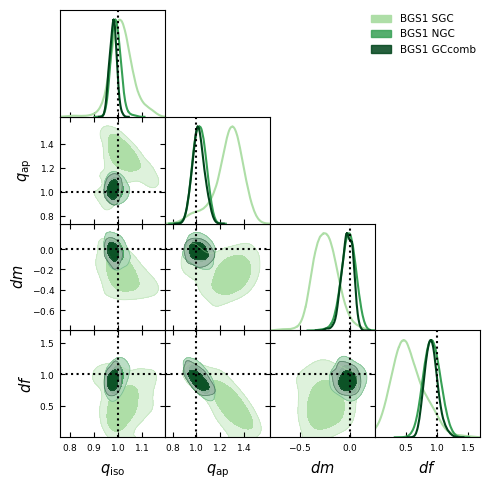

In [6]:
# posterior corener plot
# fit settings
fit       = 'SF'
cosmology = 'LCDM' # LCDM, nuCDM, w0waCDM
theory = 'vel'
task = f'{fit}fit_{cosmology}_{theory}'

# load all the chains
(mcmc_args, getdist_args) = get_mcmc_plot_args(task)
(remove_burnin , slice_step) = (mcmc_args[key] for key in ['remove_burnin', 'slice_step'])

params = mcmc_args['params']
option = '_wide_sp_prior'
for ind_col, (tracer, zrange) in enumerate([('BGS', (0.1,0.4))]):
    chains = []
    colors = []
    labels = []
    # colormap = get_cmap('inferno')(np.linspace(0, 1, 6))
    map = 'vidirs'
    if tracer == 'BGS': 
        colormap = get_cmap('Greens')(np.linspace(0, 1, 4))[:]
    if tracer == 'LRG':
        colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]
    if tracer == 'ELG': 
        colormap = get_cmap('Blues')(np.linspace(0, 1, 4))[:]
    if tracer == 'QSO': 
        colormap = get_cmap('Purples')(np.linspace(0, 1, 4))[:]
    for itask, region in enumerate(['SGC', 'NGC', 'GCcomb']):
        param_value = []
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        tracer_label = get_namespace(tracer, zrange)
        dir = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/test'
        chain_fn = dir +f'/full-shape/mcmc/chain_{fit}fit_LCDM_vel_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_default_fkp{option}.npy'
        chain = Chain.load(chain_fn).remove_burnin(remove_burnin)[::slice_step]
        chains.append(chain)
        colors.append(tuple(colormap[itask+1]))
        labels.append(f'{tracer_label} {region}')
        # print(region, chain.to_stats(params = ['logA','b1p'], tablefmt='pretty'))
    g = plots.get_subplot_plotter()
    g.settings.fig_width_inch= 5
    g.settings.legend_fontsize = 12
    g.settings.axes_labelsize = 15
    g.settings.figure_legend_frame = False
    plotting.plot_triangle(chains, 
                            params = params,
                            legend_labels = labels, legend_loc= 'upper right',
                            contour_lws = 1.5, contour_colors = colors, contour_ls = ['-', '-', '-', '-'],
                            smoothed=True, show=False, filled = [True,True,True,True], g=g
                            )
    true_values = mcmc_args['true_values']
    for i, pi in enumerate(params):
        for j, pj in enumerate(params[:i+1]):
            ax = g.subplots[i, j]
            ax.axvline(true_values[pj], c='k', ls=':', lw=1.5)
            if i != j:
                ax.axhline(true_values[pi], c='k', ls=':', lw=1.5)
        g.fig.savefig(SAVE_DIR+f'/plots/corner_{fit}_{tracer_label}_GCcompare', dpi=300, bbox_inches='tight')
    plt.show()

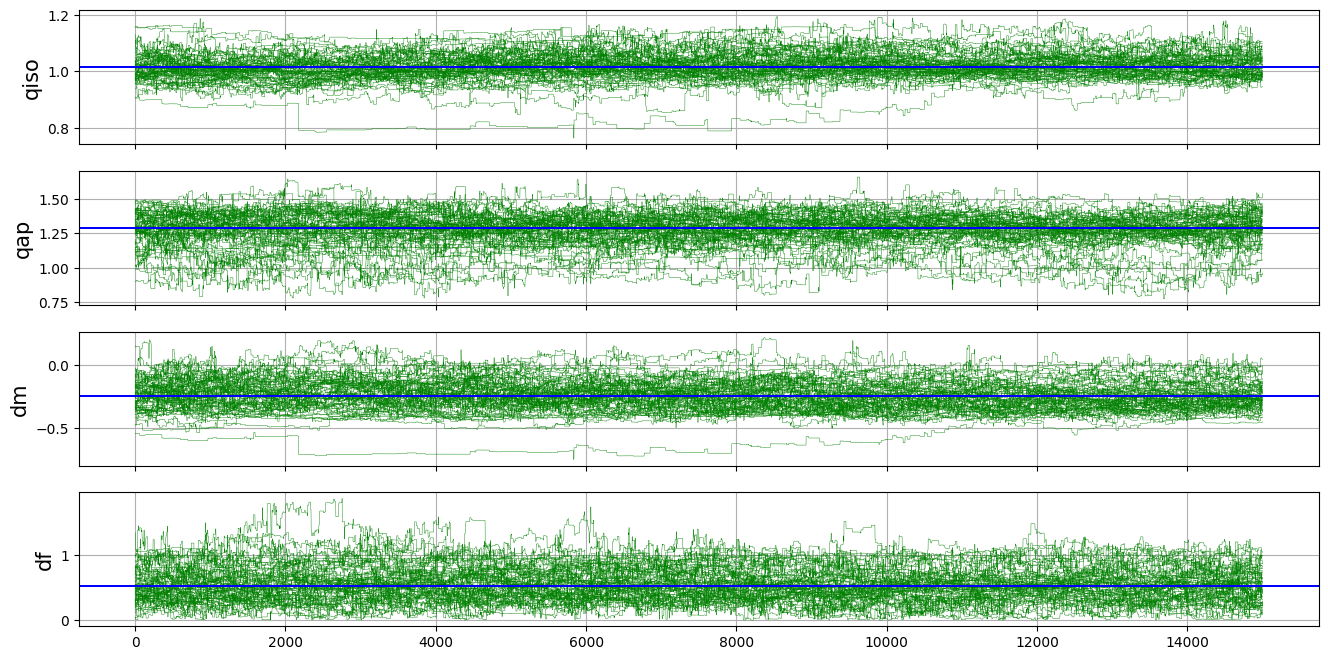

In [4]:
option = '_wide_sp_prior'
dir = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/test'
chain_fn = dir +f'/full-shape/mcmc/chain_{fit}fit_LCDM_vel_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_SGC_default_fkp{option}.npy'
chain = Chain.load(chain_fn).remove_burnin(remove_burnin)
plot_mcmc_walkers(chain, params = mcmc_args['params'], nwalkers=64)

Removed no burn in


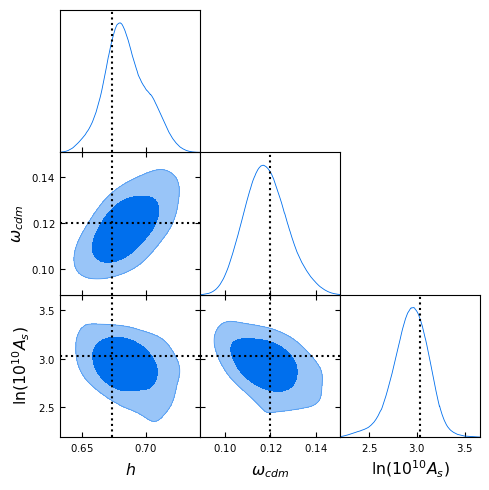

In [21]:
# posterior corener plot
# fit settings
fit       = 'FM'
cosmology = 'LCDM' # LCDM, nuCDM, w0waCDM
theory = 'vel'
task = f'{fit}fit_{cosmology}_{theory}'


tracer = 'LRG'
region = 'noDES'
zrange = (0.4,0.6)

# load all the chains
(mcmc_args, getdist_args) = get_mcmc_plot_args(task)
(remove_burnin , slice_step) = (mcmc_args[key] for key in ['remove_burnin', 'slice_step'])
params = mcmc_args['params']

param_value = []
if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
tracer_label = get_namespace(tracer, zrange)
dir = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results'
chain_fn = dir +f'/full-shape/mcmc/chain_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_default_fkp.npy'
chain = Chain.load(chain_fn).remove_burnin(remove_burnin)[::slice_step]

g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 5
g.settings.legend_fontsize = 12
g.settings.axes_labelsize = 15
g.settings.figure_legend_frame = False
plotting.plot_triangle(chain, 
                        params = params, legend_loc= 'upper right',
                        smoothed=True, show=False, filled = [True,True,True,True], g=g
                        )
true_values = mcmc_args['true_values']
for i, pi in enumerate(params):
    for j, pj in enumerate(params[:i+1]):
        ax = g.subplots[i, j]
        ax.axvline(true_values[pj], c='k', ls=':', lw=1.5)
        if i != j:
            ax.axhline(true_values[pi], c='k', ls=':', lw=1.5)
plt.show()